In [577]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox
from src.plots import plot_quant_vs_ogtt

import importlib
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [590]:
fr = pd.read_csv('../data/interim/Final_Results_validation.csv')
fr = fr.drop(fr.filter(regex='Unnamed').columns, axis=1)
# Log2 transform
fr.loc[:, fr.filter(regex='.raw').columns] = np.log2(fr.loc[:, fr.filter(regex='.raw').columns])
fr['Area (max)'] = np.log2(fr['Area (max)'])
# rename to shorter column names
combined_col_names = {fr_name: combined_name for fr_name, combined_name in zip(fg['fr_name'], fg.index)}
fr.rename(combined_col_names, axis=1, inplace=True)
data_cols = fg.index

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
# apval = pd.read_excel(r'../data/metadata/animal_phenotypes_validation.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [591]:
# fg['File Name_lipid'] = fg['fr_name'].str.split('.raw').str[0]
# fg.to_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv')

## Quant boxplots across runs

In [592]:
rawdata = (fr
 .filter(regex='_RBG')
 .loc[:, fg.loc[fg['validation']].index]
)
rawdata

,1061_10_RBG,1061_8_RBG,1075_10_RBG,1075_8_RBG,1075_9_RBG,1081_10_RBG,1081_8_RBG,1094_8_RBG,1095_8_RBG,1095_9_RBG,...,1754_31_RBG,1754_32_RBG,1788_34_RBG,1789_34_RBG,1798_32_RBG,1809_31_RBG,1810_31_RBG,1811_31_RBG,1812_31_RBG,1857_26_RBG
0,20.595650,20.329059,21.275588,19.890720,20.305111,20.624569,17.982417,20.429514,20.778168,20.169982,...,19.724045,19.662611,20.042113,19.337348,19.761105,19.776159,20.343806,19.414435,19.873880,20.182304
1,22.891224,22.691779,22.856632,19.170929,22.589884,22.601662,21.976668,22.696376,22.632233,22.891701,...,22.594191,22.534285,22.533864,22.509026,22.774511,19.887984,23.036348,20.483189,20.127469,20.737197
2,20.552374,20.803577,20.426268,20.171924,20.680448,20.643154,19.822770,20.622429,20.619401,20.411305,...,19.235178,19.837594,20.482911,20.378540,19.218898,19.313885,20.004291,19.378119,20.488194,19.407002
3,25.586711,25.413092,24.866927,25.809375,24.941648,24.617808,24.515867,25.515966,25.168032,25.310212,...,25.329266,25.644253,23.658920,25.681307,25.080814,25.097354,25.082007,25.856958,23.425071,25.555880
4,21.825884,22.077087,21.699778,21.445434,21.953958,21.916663,21.096280,21.895939,21.892911,21.847956,...,21.600211,21.715514,21.756421,21.104216,20.868855,21.073510,21.004898,20.651629,21.155603,20.709187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6501,16.938164,16.683832,16.827108,16.965972,16.950119,17.112155,16.778905,16.747801,16.921212,16.857466,...,16.675976,16.693883,16.608689,16.730248,16.604852,16.637867,16.719759,16.521666,16.670007,16.734581
6502,17.009468,16.755136,16.898412,17.037276,17.021423,17.183459,16.850209,16.819105,16.992516,16.928770,...,16.747280,16.765187,16.679993,16.801552,16.676156,16.709171,16.791063,16.592970,16.741311,16.805886
6503,16.836873,16.582541,16.725817,16.864681,16.848828,17.010864,16.677614,16.646510,16.819921,16.756175,...,16.574685,16.592592,16.507398,16.628957,16.503561,16.536577,16.618468,16.420375,16.568716,16.633291
6504,17.447654,17.193322,17.336598,17.475462,17.459609,17.621646,17.288396,17.257291,17.430702,17.366956,...,17.185466,17.203374,17.118179,17.239738,17.114342,17.147358,17.229249,17.031156,17.179498,17.244072


In [593]:
## Input observations in rows, features in columns
def make_pca(normdf, cohorts=['10wk', '30wk']):
    ss = StandardScaler()
    scaled = ss.fit_transform(normdf)
    scaled = pd.DataFrame(scaled, columns=normdf.columns, index=normdf.index)
    pca = PCA()
    pca_data = pca.fit_transform(scaled)
    pca_data = pd.DataFrame(pca_data, 
                            columns=[f'pc_{x}' for x in range(1, pca.n_components_+1)],
                            index=normdf.index)
    
    pca_data = pca_data.join(fg[['cohort', 'animal']])
    pca_data['animal'] = pca_data['animal'].astype('str')

    fig1, ax1 = plt.subplots(dpi=150, figsize=(5, 4))
    pca_data = pca_data.loc[pca_data['cohort'].isin(cohorts)]
    sns.scatterplot(
        data=pca_data, ax=ax1,
        x='pc_1', y='pc_2', style='cohort',
        hue='animal'
    )
    plt.legend(loc=(1.02, 0), fontsize=6)
    
    
    run_order = fg.loc[fg['validation'] & fg['quant_file']].sort_values('lipid_run_order').index
    fig2, ax2 = plt.subplots(dpi=100, figsize=(9, 3))
    sns.boxenplot(
        data=normdf.loc[run_order].T, ax=ax2,
    )
    ax2.tick_params(rotation=90, labelsize=6)
    return pca_data, ax1, ax2

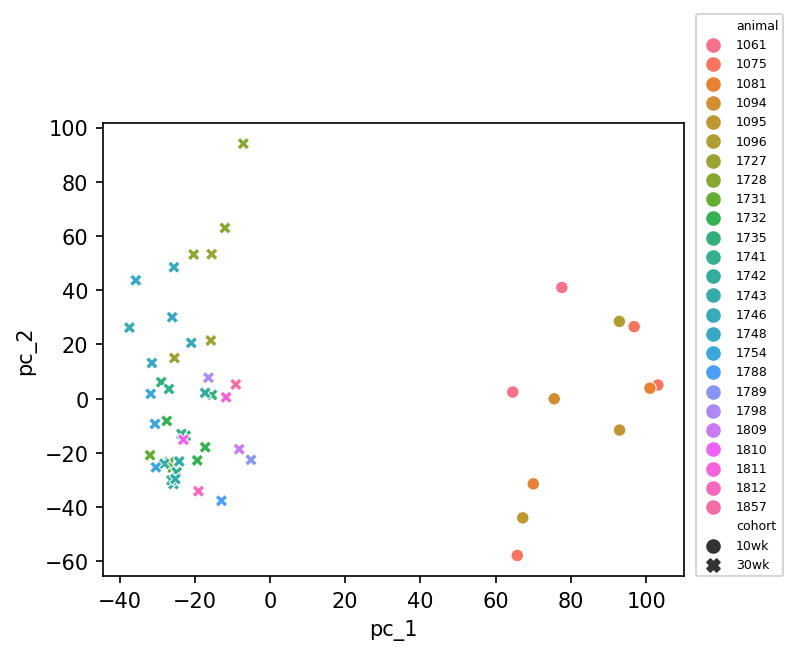

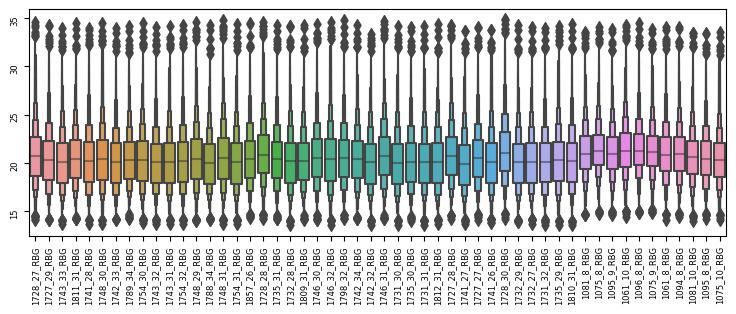

In [594]:
_ = make_pca(rawdata.T)

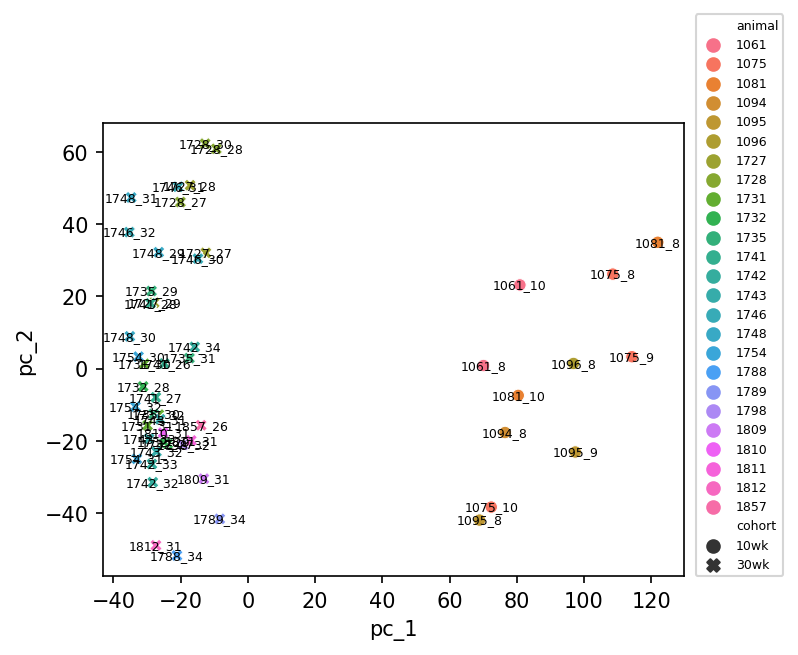

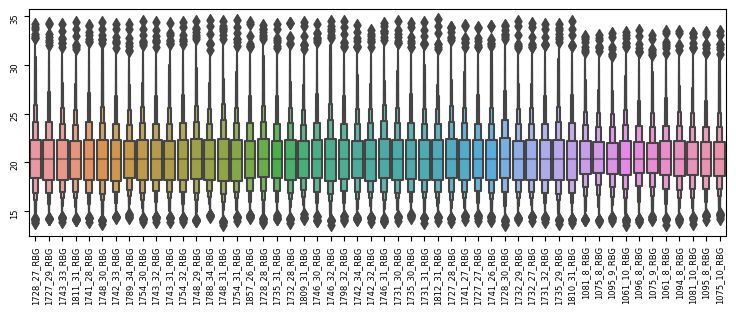

In [597]:
med_of_med_diff = rawdata.median(axis=0) - rawdata.median(axis=0).median()
# data.add()
med_norm = rawdata.sub(med_of_med_diff, axis=1).T
med_norm
pca_data, ax1, ax2 = make_pca(med_norm)
for i, row in pca_data.iterrows():
    ax1.text(row['pc_1'], row['pc_2'], str(i)[:-4], ha='center', va='center', fontsize=6)

Index(['1830', '1966', '1996', '2089', '2110', '2159', '2201', '2289', '3140',
       '3545', '4773', '4879', '5282', 'ogtt', 'sex', 'animal', 'cohort',
       'group'],
      dtype='object')

Text(0.5, 1.0, 'TG 22:6_22:6_22:6')

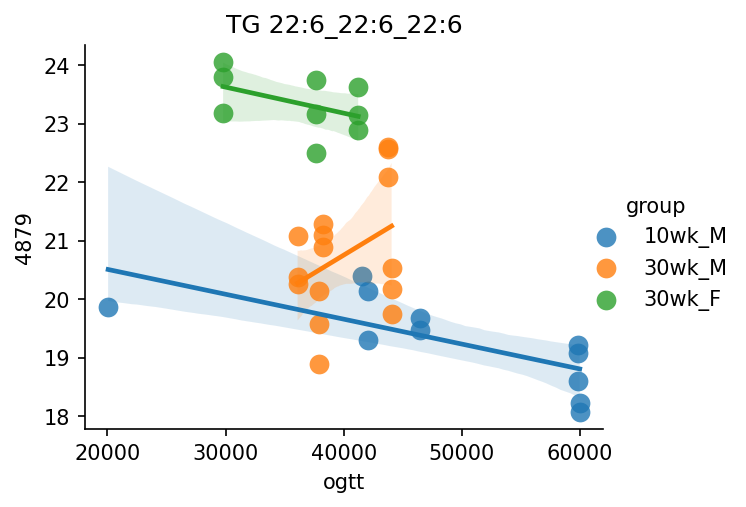

In [611]:
animal_subset = ap.loc[(ap['validation']) & ~(ap['OGTT (AUC)'].isna())].index
df = fr.loc[:, fg.loc[(fg['animal'].isin(animal_subset)) & (fg['validation'])].index]
# df = df.join(fr['Identification'])

top_feat_ids = [
    'CE 18:1', 
    'Plasmanyl-PC O-20:0_20:4', 
    'FA 18:0',
    'PC 36:3', 'PC 38:7', 
    '4-Guanidinobutyric acid', 
    'SM d37:1',
    'TG 20:5_22:6_22:6', 'TG 22:6_22:6_22:6', 'TG 18:1_22:6_22:6',
]
df = df.loc[fr['Identification'].isin(top_feat_ids)]
df = df.T
df = df.join(fg[['ogtt', 'sex', 'animal', 'cohort']])
df['ogtt']
df.columns = df.columns.astype('str')
df['group'] = df['cohort'] + '_' + df['sex']
# df = df.drop(fg.loc[~fg['sufficient_sample']].index)
display(df.columns)
# df = df.loc[~(df['group'] == '10wk_M')]


feature = '4879'
# fig, ax = plt.subplots(dpi=300, figsize=(4, 3))
sns.lmplot(
    data=df, y=feature, x='ogtt',
    hue='group', 
    scatter_kws=dict(lw=0, s=90)
)
fig = plt.gcf()
fig.set_dpi(150)
fig.set_size_inches(5, 3)
fig.set_facecolor('white')
plt.title(fr.loc[int(feature), 'Identification'])

# for animal in animal_subset:
#     if apval.loc[animal, 'sex'] == 'F':
#         plt.axvline(apval.loc[animal, 'OGTT(AUC)'], color='0.1', lw=0.5)

### Get lipid run order

In [452]:
# order = {}
# for file in Path('../data/raw/lipidomics/').glob('*.raw'):
#     if 'BJA-Nilerat' not in str(file):
#         continue
#     mtime = file.stat().st_mtime  # modified time (ctime = creation time doesn't order correctly)
#     order[str(file.stem)] = mtime
# order = pd.Series(order, name='lipid_run_order').rank().sort_values()
# order

BJA-Nilerat-20220915_lipid_1700s_water_blank_rep1            1.0
BJA-Nilerat-20220915_lipid_1700s_extract_blank_rep1          2.0
BJA-Nilerat-20220915_lipid_1700s_resuspension_blank_rep1     3.0
BJA-Nilerat-20220915_lipid_1700s_QC100uL_rep1                4.0
BJA-Nilerat-20220915_lipid_1728M_27wk_0606                   5.0
                                                            ... 
BJA-Nilerat-20220919_lipid_1000s_QC100uL_dil_rep2           94.0
BJA-Nilerat-20220919_lipid_1000s_QC150uL_dil_rep2           95.0
BJA-Nilerat-20220919_lipid_1000s_QC200uL_dil_rep2           96.0
BJA-Nilerat-20220919_lipid_1000s_resuspension_blank_rep2    97.0
BJA-Nilerat-20220919_lipid_1000s_water_blank_rep2           98.0
Name: lipid_run_order, Length: 98, dtype: float64

### Validate OGTT AUC calculation, write correct value 

In [45]:
# ogtt_timepoints = apval.filter(regex='OGTT \(').columns
# for i, row in apval.iterrows():
#     try: 
#         trap = np.trapz(y=row[ogtt_timepoints].values, x=[0, 10, 20, 30, 60, 120])
        
#         print(trap, row['OGTT(AUC)'])
#         apval.loc[i, 'OGTT(AUC)'] = trap
#         print(trap == row['OGTT(AUC)'] )
#     except:
#         print(i)
#         pass
# apval.to_excel(r'../data/metadata/animal_phenotypes_validation.xlsx')

## Make file grouping df

In [182]:
# sample_data = pd.read_excel('../data/metadata/second round plasma samples.xlsx')
# sample_data.index = sample_data['animal'].astype('str') + '_' + sample_data['week'].astype('str') + '_RBG'
# sample_data

# file_metadata = {}
# splits = {x: x.split('.')[0].split('_') for x in fr.filter(regex='.raw').columns}
# for file, split in splits.items():
# #     print(split)
#     d = file_metadata[file] = {}
#     if '1700s' in split or '1000s' in split:
#         continue
# #         d['cohort'] = split[2]
# #         if 'blank' in split:
# #             d['blank'] = True
# #         else:
# #             d['blank'] = False
# #         if 'dil' in split:
# #             d['QC_dilution'] = True
# #         else:
# #             d['QC_dilution'] = False
# #         if 'QC' in split[3] and 'rep' in split[4]:
# #             d['QC_rep'] = True
# #         else:
# #             d['QC_rep'] = False
#     else:
#         if split[2][:2] == '10':
#             d['cohort'] = '1000s'
#         else:
#             d['cohort'] = '1700s'
#         d['animal'] = split[2][:-1]
#         d['week'] = split[3][:-2]

# fgval = pd.DataFrame(file_metadata).T#.replace(np.nan, False)
# fgval['fr_name'] = fgval.index
# fgval.index = fgval['animal'].astype('str') + '_' + fgval['week'].astype('str') + '_RBG'
# fgval = sample_data.join(fgval, lsuffix='_l', rsuffix='_r')
# fgval = fgval.drop(fgval.loc[fgval['cohort'].isna()].index)
# fgval = fgval.drop(['rat', 'animal_r', 'week_r', 'batch', 'include', 'Huishi note', 'Ben note'], axis=1)
# fgval.rename({'animal_l': 'animal', 'week_l': 'week'}, axis=1, inplace=True)
# fgval['date'] = pd.to_datetime(fgval['date'], format='%Y%m%d')
# fgval['ogtt'] = fgval['animal'].map(apval['OGTT(AUC)'])
# # fgval.to_csv('../data/metadata/file_grouping_validation.csv')
# fgval

,animal,week,color,date,sex,cohort,fr_name,ogtt
1061_10_RBG,1061,10,slightly pink,2022-04-08,M,1000s,BJA-Nilerat-20220919_lipid_1061M_10wk_0408.raw...,NaN
1061_8_RBG,1061,8,slightly pink,2022-03-25,M,1000s,BJA-Nilerat-20220919_lipid_1061M_8wk_0325.raw ...,NaN
1061_9_RBG,1061,9,clear,2022-04-01,M,1000s,BJA-Nilerat-20220919_lipid_1061M_9wk_0401.raw ...,NaN
1075_10_RBG,1075,10,clear,2022-04-08,M,1000s,BJA-Nilerat-20220919_lipid_1075M_10wk_0408.raw...,NaN
1075_8_RBG,1075,8,slightly pink,2022-03-25,M,1000s,BJA-Nilerat-20220919_lipid_1075M_8wk_0325.raw ...,NaN
1075_9_RBG,1075,9,clear,2022-04-01,M,1000s,BJA-Nilerat-20220919_lipid_1075M_9wk_0401.raw ...,NaN
1081_10_RBG,1081,10,clear,2022-04-08,M,1000s,BJA-Nilerat-20220919_lipid_1081M_10wk_0408.raw...,NaN
1081_8_RBG,1081,8,clear,2022-03-25,M,1000s,BJA-Nilerat-20220919_lipid_1081M_8wk_0325.raw ...,NaN
1081_9_RBG,1081,9,clear,2022-04-01,M,1000s,BJA-Nilerat-20220919_lipid_1081M_9wk_0401.raw ...,NaN
1094_10_RBG,1094,10,clear,2022-04-13,M,1000s,BJA-Nilerat-20220919_lipid_1094M_10wk_0413.raw...,NaN


In [360]:

val_data_cols = list(combined_col_names.values())
animal_subset = ap.loc[(ap['validation']) & ~(ap['OGTT (AUC)'].isna())].index
df = fr.loc[:, fg.loc[fg['animal'].isin(animal_subset)].index]
# df = df.join(fr['Identification'])

top_feat_ids = [
    'CE 18:1', 
    'Plasmanyl-PC O-20:0_20:4', 
    'FA 18:0',
    'PC 36:3', 'PC 38:7', 
    '4-Guanidinobutyric acid', 
    'SM d37:1',
    'TG 20:5_22:6_22:6', 'TG 22:6_22:6_22:6', 'TG 18:1_22:6_22:6',
]
df = df.loc[fr['Identification'].isin(top_feat_ids)]
df = df.T
df = df.join(fg[['ogtt', 'sex', 'animal', 'cohort']])
df['ogtt']
df.columns = df.columns.astype('str')
df['group'] = df['cohort'] + '_' + df['sex']
df = df.drop(fg.loc[~fg['sufficient_sample']].index)
df

,1830,1966,1996,2089,2110,2159,2201,2289,3140,3545,4773,4879,5282,ogtt,sex,animal,cohort,group
combined_col_name,,,,,,,,,,,,,,,,,,
1061_10_RBG,25.324807,21.941646,24.285038,27.716620,24.748351,26.351324,23.436594,21.990199,24.720621,23.578112,21.260966,19.479153,23.934075,46485.0,M,1061,10wk,10wk_M
1061_8_RBG,24.208421,22.374336,24.073856,27.118570,24.482412,25.658654,23.582796,21.721944,24.545664,23.002075,18.566460,19.678198,23.310267,46485.0,M,1061,10wk,10wk_M
1075_10_RBG,23.738450,21.260289,23.256868,26.913097,23.263696,25.034547,22.778065,22.778065,23.408507,22.172650,17.260171,18.606534,21.096126,59782.5,M,1075,10wk,10wk_M
1075_8_RBG,24.759737,21.915073,23.461213,26.994475,24.044844,25.351910,22.127520,21.424043,24.067692,22.819542,18.855288,19.222366,24.411635,59782.5,M,1075,10wk,10wk_M
1075_9_RBG,24.155956,21.448268,23.923998,27.222149,24.047615,25.373237,22.006235,22.482549,23.882740,22.713725,18.292989,19.077829,22.819096,59782.5,M,1075,10wk,10wk_M
1081_10_RBG,23.613243,21.208954,23.096436,26.205015,22.221283,25.139893,22.197534,20.201087,23.356456,22.729819,17.053424,18.223931,23.220263,59965.0,M,1081,10wk,10wk_M
1081_8_RBG,23.390812,20.531394,23.523885,27.095582,22.004286,24.669404,22.034196,21.996380,23.354610,22.812508,19.581463,18.077546,20.254608,59965.0,M,1081,10wk,10wk_M
1081_9_RBG,22.003062,19.282370,21.277702,24.005507,20.741704,23.291700,19.531701,17.921936,21.408768,20.266023,16.299720,16.753726,19.513119,59965.0,M,1081,10wk,10wk_M
1094_10_RBG,20.512296,17.438513,20.143834,23.027452,22.050735,21.707848,20.006366,20.006366,20.561144,19.616670,15.995318,16.363302,16.282574,20055.0,M,1094,10wk,10wk_M


Text(0.5, 1.0, 'TG 22:6_22:6_22:6')

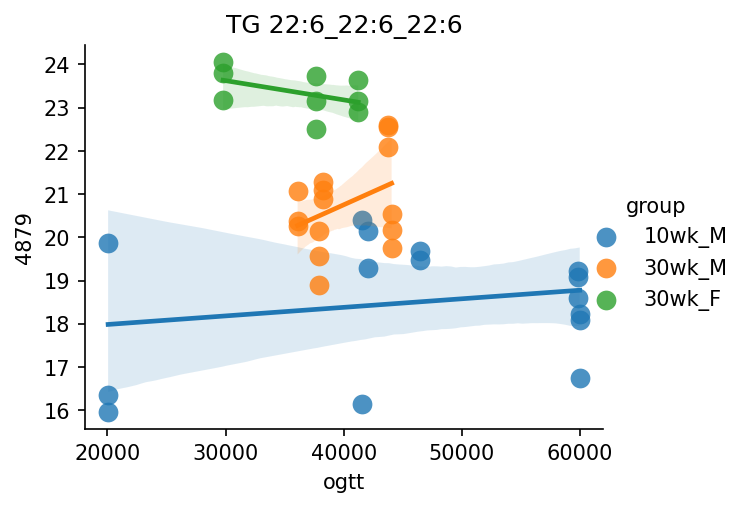

In [370]:
feature = '4879'
# fig, ax = plt.subplots(dpi=300, figsize=(4, 3))
sns.lmplot(
    data=df, y=feature, x='ogtt',
    hue='group', 
    scatter_kws=dict(lw=0, s=90)
)
fig = plt.gcf()
fig.set_dpi(150)
fig.set_size_inches(5, 3)
fig.set_facecolor('white')
plt.title(fr.loc[int(feature), 'Identification'])
# for animal in animal_subset:
#     if apval.loc[animal, 'sex'] == 'F':
#         plt.axvline(apval.loc[animal, 'OGTT(AUC)'], color='0.1', lw=0.5)